In [1]:
import pandas as pd 
df = pd.read_csv("/home/cv/Desktop/cc3m_full_with_path.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/cv/Desktop/cc3m_full_with_path.csv'

In [ ]:
df

,url,key,status,width,height,exif,caption,alt_txt,path
0,https://ak0.picdn.net/shutterstock/videos/3380...,1470004,success,852.0,480.0,{},the effect of moving the large colored particl...,"""""",/home/temp/Desktop/ccm3_full/00147/001470004.jpg
1,https://ak9.picdn.net/shutterstock/videos/2377...,1470024,success,852.0,480.0,{},wing of an airplane passing over clouds at hig...,"""""",/home/temp/Desktop/ccm3_full/00147/001470024.jpg
2,https://ak7.picdn.net/shutterstock/videos/1292...,1470042,success,852.0,480.0,{},man holding the keys to her new car in a motor...,"""""",/home/temp/Desktop/ccm3_full/00147/001470042.jpg
3,https://ak9.picdn.net/shutterstock/videos/1147...,1470044,success,852.0,480.0,{},background with particles and stars .,"""""",/home/temp/Desktop/ccm3_full/00147/001470044.jpg
4,https://ak8.picdn.net/shutterstock/videos/5176...,1470039,success,852.0,480.0,{},food canned in mason jars on shelves in a stor...,"""""",/home/temp/Desktop/ccm3_full/00147/001470039.jpg
...,...,...,...,...,...,...,...,...,...
2555423,http://l7.alamy.com/zooms/5f24d20339df4077a506...,2199920,success,640.0,447.0,{},senior woman in the park,"""""",/home/temp/Desktop/ccm3_full/00219/002199920.jpg
2555424,http://l7.alamy.com/zooms/7c2ad41134dc4b1984d9...,2199914,success,640.0,446.0,{},remote house in the forest by lake,"""""",/home/temp/Desktop/ccm3_full/00219/002199914.jpg
2555425,http://l7.alamy.com/zooms/0dd49ace792a4db6be39...,2199999,success,640.0,448.0,{},wind blown tree on the beach,"""""",/home/temp/Desktop/ccm3_full/00219/002199999.jpg
2555426,http://l7.alamy.com/zooms/28f1e935be484181a90c...,2199994,success,640.0,447.0,{},snow covered city park in a winter day .,"""""",/home/temp/Desktop/ccm3_full/00219/002199994.jpg


In [ ]:
from dataset import * 
from tqdm import tqdm 

: 

: 

In [ ]:
from torchvision import datasets, transforms
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Resize((224, 224))
    ])
dataset = Mnist(None, transform)

In [ ]:
from PIL import ImageFont, ImageDraw, Image 

def render_text(txt:str, image_size: int=224, font_size: int = 16, max_chars=768,
                       background_brightness=127, text_brightness=0,
                       lower=True, monospace=False, spacing=1, min_width=4,
                       resize_method="area", max_width=28):
    if len(txt)> max_chars:
        txt = txt[:max_chars]
    if lower: 
        txt = txt.lower() 
    wrapper = textwrap.TextWrapper(width=max_width)
    lines = wrapper.wrap(txt) 
    new_txt = ""
    for line in lines: 
        new_txt+= line+'\n'
    image = Image.new("RGBA", (image_size*3,image_size*3), (background_brightness,background_brightness,background_brightness))
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("/home/cv/Desktop/KD/CLIPPO/unifont-15.0.06.otf", font_size*3)
    draw.text((0, 0), new_txt, (text_brightness,text_brightness,text_brightness), font=font, spacing=spacing)
    img_resized = image.resize((image_size,image_size), Image.ANTIALIAS)
    return img_resized


In [ ]:
import torch 
from network import CLIPPO
from tim_and_bert import * 
clippo = CLIP()
clippo = clippo.cpu()
clippo.load_state_dict(torch.load("/home/cv/Desktop/KD/CLIPPO/clip.pt")) 

: 

: 

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.decomposition import PCA

/home/cv/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
features = []
labels_ar = [] 
clippo = clippo.cuda(1)
clippo.eval() 
valid_loader = torch.utils.data.DataLoader(dataset, 2000, shuffle=False, num_workers=32)
for images, labels in valid_loader: 
    with torch.no_grad():
        out, _= clippo(torch.tensor(labels).cuda(1), images.cuda(1))#.squeeze()
        out = out
        features.append(out)
        labels_ar.append(labels[None, :])

features = torch.concat(features).cpu().detach().numpy()
labels_ar = torch.concat(labels_ar, dim=1).detach().numpy()

NameError: name 'clippo' is not defined

In [ ]:
tsne = TSNE().fit_transform(features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.3
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

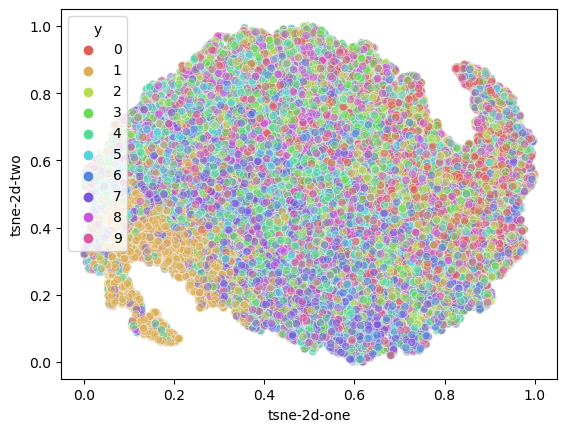

In [ ]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.5
)

In [ ]:
labels_ar.shape

(1, 60000)

In [ ]:
features.shape

(60000, 512)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels_ar.squeeze(), test_size=0.33, random_state=42)

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(X_train, y_train)

/home/temp/miniconda3/envs/stanford_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

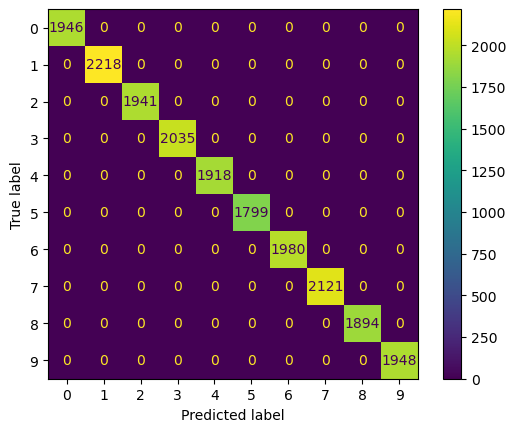

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

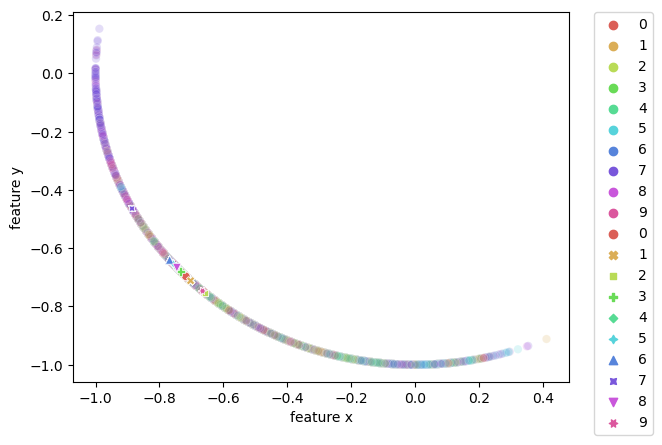

In [4]:
import pandas as pd 
from dataset import * 
import torch 
from network import *
from tim_and_bert import * 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import torchvision.transforms as T


class CLIPPO2(nn.Module): 
    def __init__(self, timm_model:Union[str, None]=None): 
        super(CLIPPO2, self).__init__()
        self.encoder = nn.Sequential(*[nn.Conv2d(3, 32, 3),
                                        nn.ReLU(), 
                                        nn.Conv2d(32, 64, 3), 
                                        nn.ReLU(), 
                                        nn.Flatten(), 
                                        nn.AdaptiveMaxPool1d(124), 
                                        nn.Linear(124, 512)])
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.image_proj = nn.Sequential(*[nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 2)])

    def forward(self, image, text): 
        image_features = self.image_proj(self.encoder(image))
        text_features = self.image_proj (self.encoder(text))
        return image_features, text_features


clippo = CLIPPO()
clippo = clippo.cpu()
#clippo.load_state_dict(torch.load("arcCLip.pt"), strict=True) 

from torchvision import datasets, transforms
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Resize((32, 32))
    ])
dataset = TestMnist(transform, transform)

features = []
labels_ar = [] 
clippo = clippo.cuda(1)
clippo.eval() 
valid_loader = torch.utils.data.DataLoader(dataset, 6000, shuffle=False, num_workers=32)
for images, _, labels in valid_loader: 
    with torch.no_grad():
        out = clippo.proj(clippo.encoder(images.cuda(1)))
        out /=out.norm(dim=1, keepdim=True)
        features.append(out)
        labels_ar.append(labels[None, :])

features = torch.concat(features).cpu().detach().numpy()
labels_ar = torch.concat(labels_ar, dim=1).detach().numpy()
tx, ty = features[:,0], features[:,1]


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.2
)


features_centers = []
labels_ar_centers = [] 
for _, images, labels in valid_loader: 
    with torch.no_grad():
        out = clippo.proj(clippo.encoder(images.cuda(1)))
        out /=out.norm(dim=1, keepdim=True)
        features_centers.append(out)
        labels_ar_centers.append(labels[None, :])


features_centers = torch.concat(features_centers).cpu().detach().numpy()
labels_ar_centers = torch.concat(labels_ar_centers, dim=1).detach().numpy()
tx, ty = features_centers[:,0], features_centers[:,1]


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    style="y",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=1
)
#plt.title('Exploring Physical Attributes of Different Penguins')
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

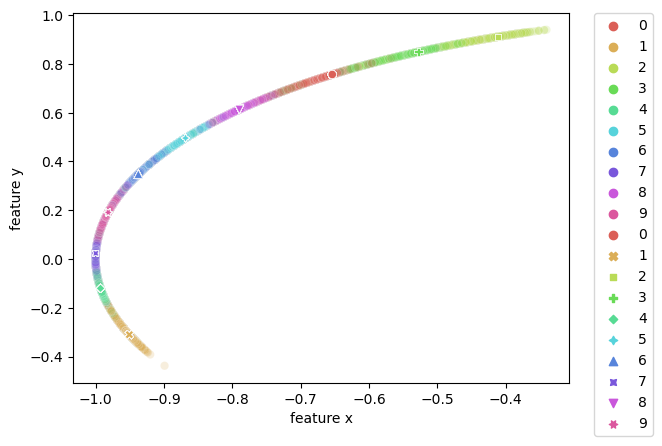

In [21]:
import pandas as pd 
from dataset import * 
import torch 
from network import *
from tim_and_bert import * 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import torchvision.transforms as T


class CLIPPO2(nn.Module): 
    def __init__(self, timm_model:Union[str, None]=None): 
        super(CLIPPO2, self).__init__()
        self.encoder = nn.Sequential(*[nn.Conv2d(3, 32, 3),
                                        nn.ReLU(), 
                                        nn.Conv2d(32, 64, 3), 
                                        nn.ReLU(), 
                                        nn.Flatten(), 
                                        nn.AdaptiveMaxPool1d(124), 
                                        nn.Linear(124, 512)])
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.image_proj = nn.Sequential(*[nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 2)])

    def forward(self, image, text): 
        image_features = self.image_proj(self.encoder(image))
        text_features = self.image_proj (self.encoder(text))
        return image_features, text_features


clippo = CLIPPO()
clippo = clippo.cpu()
clippo.load_state_dict(torch.load("whataaaa_4.pt"), strict=True) 

from torchvision import datasets, transforms
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Resize((32, 32))
    ])
dataset = TestMnist(transform, transform)

features = []
labels_ar = [] 
clippo = clippo.cuda(1)
clippo.eval() 
valid_loader = torch.utils.data.DataLoader(dataset, 6000, shuffle=False, num_workers=32)
for images, _, labels in valid_loader: 
    with torch.no_grad():
        out = clippo.proj(clippo.encoder(images.cuda(1)))
        out /=out.norm(dim=1, keepdim=True)
        features.append(out)
        labels_ar.append(labels[None, :])

features = torch.concat(features).cpu().detach().numpy()
labels_ar = torch.concat(labels_ar, dim=1).detach().numpy()
tx, ty = features[:,0], features[:,1]


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.2
)


features_centers = []
labels_ar_centers = [] 
for _, images, labels in valid_loader: 
    with torch.no_grad():
        out = clippo.proj(clippo.encoder(images.cuda(1)))
        out /=out.norm(dim=1, keepdim=True)
        features_centers.append(out)
        labels_ar_centers.append(labels[None, :])


features_centers = torch.concat(features_centers).cpu().detach().numpy()
labels_ar_centers = torch.concat(labels_ar_centers, dim=1).detach().numpy()
tx, ty = features_centers[:,0], features_centers[:,1]


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    style="y",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=1
)
#plt.title('Exploring Physical Attributes of Different Penguins')
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

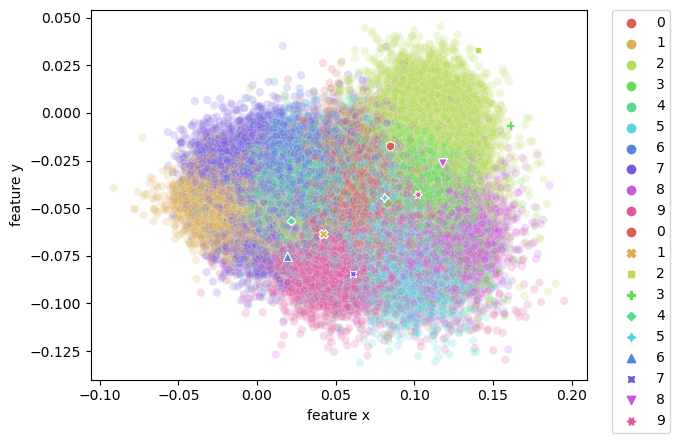

In [12]:
import pandas as pd 
from dataset import * 
import torch 
from network import *
from tim_and_bert import * 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import torchvision.transforms as T


class CLIPPO2(nn.Module): 
    def __init__(self, timm_model:Union[str, None]=None): 
        super(CLIPPO2, self).__init__()
        self.encoder = nn.Sequential(*[nn.Conv2d(3, 32, 3),
                                        nn.ReLU(), 
                                        nn.Conv2d(32, 64, 3), 
                                        nn.ReLU(), 
                                        nn.Flatten(), 
                                        nn.AdaptiveMaxPool1d(124), 
                                        nn.Linear(124, 512)])
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.image_proj = nn.Sequential(*[nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 2)])

    def forward(self, image, text): 
        image_features = self.image_proj(self.encoder(image))
        text_features = self.image_proj (self.encoder(text))
        return image_features, text_features


clippo = CLIPPO()
clippo = clippo.cpu()
clippo.load_state_dict(torch.load("whataaaa_4.pt"), strict=True) 

from torchvision import datasets, transforms
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Resize((32, 32))
    ])
dataset = TestMnist(transform, transform)

features = []
labels_ar = [] 
clippo = clippo.cuda(1)
clippo.eval() 
valid_loader = torch.utils.data.DataLoader(dataset, 6000, shuffle=False, num_workers=32)
for images, _, labels in valid_loader: 
    with torch.no_grad():
        out = clippo.encoder(images.cuda(1))
        out /=out.norm(dim=1, keepdim=True)
        features.append(out)
        labels_ar.append(labels[None, :])

features = torch.concat(features).cpu().detach().numpy()
labels_ar = torch.concat(labels_ar, dim=1).detach().numpy()
tx, ty = features[:,0], features[:,1]


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.2
)


features_centers = []
labels_ar_centers = [] 
for _, images, labels in valid_loader: 
    with torch.no_grad():
        out = clippo.encoder(images.cuda(1))
        out /=out.norm(dim=1, keepdim=True)
        features_centers.append(out)
        labels_ar_centers.append(labels[None, :])


features_centers = torch.concat(features_centers).cpu().detach().numpy()
labels_ar_centers = torch.concat(labels_ar_centers, dim=1).detach().numpy()
tx, ty = features_centers[:,0], features_centers[:,1]


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    style="y",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=1
)
#plt.title('Exploring Physical Attributes of Different Penguins')
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

/home/temp/miniconda3/envs/stanford_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/temp/miniconda3/envs/stanford_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


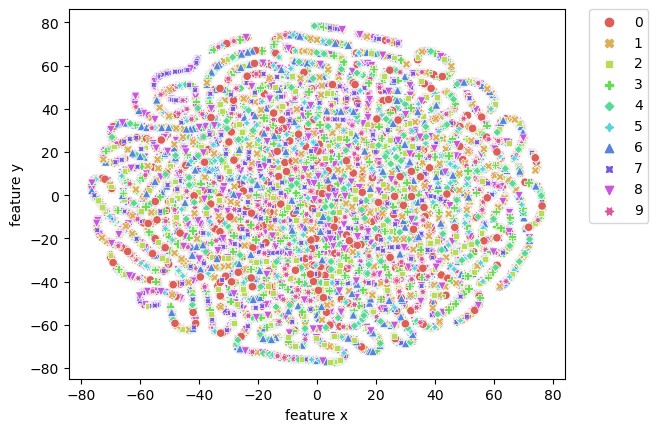

In [11]:
import numpy as np 
from sklearn.manifold import TSNE

x = np.concatenate([features], axis=0)
y = np.concatenate([labels_ar], axis=0)
tsne = TSNE(n_jobs=-1).fit_transform(x)
tx, ty = tsne[:,0], tsne[:,1]
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    # style="y",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=1
)
#plt.title('Exploring Physical Attributes of Different Penguins')
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
import numpy as np 
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(features)
tx, ty = tsne[:,0], tsne[:,1]


In [23]:
all_image_features = torch.randn(3, 3)
all_text_features = torch.randn(3, 3)
logit1 = all_image_features @ all_text_features.T
logit2 = all_text_features @ all_image_features.T

In [26]:
(logit1 == logit2)

tensor([[ True, False, False],
        [False,  True, False],
        [False, False,  True]])

In [65]:
import torch 
from torch.nn import functional as F 
dim =0
neg_ce = torch.diag(F.log_softmax(logits, dim=0))

In [73]:
ce = torch.nn.CrossEntropyLoss()
ce(logits, torch.arange(logits.shape[0], dtype=torch.long))

tensor(0.9048)

In [75]:
logits

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [74]:
torch.arange(logits.shape[0], dtype=torch.long)

tensor([0, 1, 2, 3, 4])

In [59]:
-neg_ce.mean()

tensor(0.9048)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor,**kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [29]:
tx, ty = features[:,0], features[:,1]

data=pd.DataFrame({'x':tx, 'y':ty, 'label':labels_ar.squeeze()})

In [94]:
import torch 
all_logits = torch.randn(4, 2)
gpu_logit = all_logits[2:3]

In [95]:
gpu_logit

tensor([[-0.5714, -0.3603]])

In [96]:
all_logits

tensor([[-1.8445,  2.1957],
        [-1.6229,  0.7774],
        [-0.5714, -0.3603],
        [-1.1565, -1.2190]])

In [97]:
position = torch.arange(gpu_logit.shape[0], device=gpu_logit.device) + (gpu_logit.shape[0] *1)
gpu_logit  /= all_logits.norm(dim=1, keepdim=True)[position]
all_logits /= all_logits.norm(dim=1, keepdim=True)

In [98]:
gpu_logit

tensor([[-0.8459, -0.5334]])

In [99]:
all_logits

tensor([[-0.6432,  0.7657],
        [-0.9019,  0.4320],
        [-0.8459, -0.5334],
        [-0.6882, -0.7255]])

In [100]:
logits_per_image = gpu_logit @ all_logits.T
all_kk = all_logits @ all_logits.T

In [104]:
all_kk

tensor([[ 1.0000,  0.9109,  0.1356, -0.1128],
        [ 0.9109,  1.0000,  0.5324,  0.3073],
        [ 0.1356,  0.5324,  1.0000,  0.9691],
        [-0.1128,  0.3073,  0.9691,  1.0000]])

In [105]:
logits_per_image

tensor([[0.1356, 0.5324, 1.0000, 0.9691]])

In [102]:
ce = torch.
all_kk

tensor([[ 1.0000,  0.9109,  0.1356, -0.1128],
        [ 0.9109,  1.0000,  0.5324,  0.3073],
        [ 0.1356,  0.5324,  1.0000,  0.9691],
        [-0.1128,  0.3073,  0.9691,  1.0000]])

In [103]:
logits_per_image

tensor([[0.1356, 0.5324, 1.0000, 0.9691]])

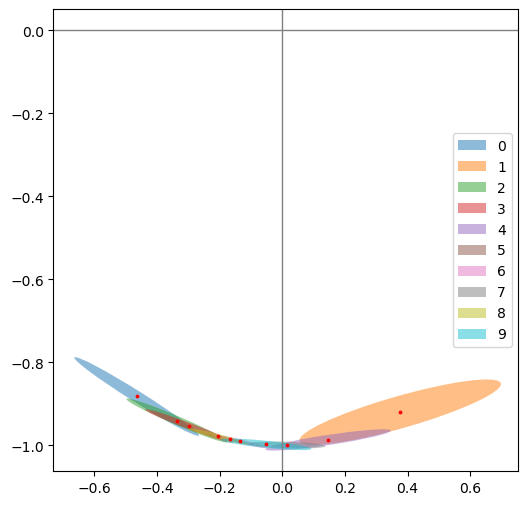

In [31]:
import matplotlib.colors as mcolors

fig, ax_kwargs = plt.subplots(figsize=(6, 6))
ax_kwargs.axvline(c='grey', lw=1)
ax_kwargs.axhline(c='grey', lw=1)
colors = mcolors.TABLEAU_COLORS
colors = list(colors)
for i in range(10): 
    sub = data[data['label']==i]
    
    mu = sub['x'].mean(), sub['y'].mean()
    x, y = sub['x'], sub['y']
    # Plot the ellipse with zorder=0 in order to demonstrate
    # its transparency (caused by the use of alpha).
    confidence_ellipse(x, y, ax_kwargs,
                    alpha=0.5, facecolor=colors[i], edgecolor=None, zorder=0, label=str(i))
    ax_kwargs.scatter(mu[0], mu[1], c='red', s=3)
    # ax_kwargs.set_title('Using keyword arguments')

    #fig.subplots_adjust(hspace=0.25)
plt.legend()
plt.show()